In [1]:
import time
import re
import pandas as pd
import numpy as np
from scipy.stats import norm, kurtosis, skew
import pickle

#data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns  
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.tools import FigureFactory as ff
import plotly.graph_objs as graph

from sklearn.preprocessing import LabelEncoder
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
# %config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%pylab inline
%config InlineBackend.figure_formats = ['retina']


#settings
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
init_notebook_mode(connected=True)

Populating the interactive namespace from numpy and matplotlib


/Users/admin/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy



In [2]:
with open('../data/raw/hdb_df.pickle', 'rb') as read_file:
    hdb_df = pickle.load(read_file)

In [3]:
hdb_df.head(3)

Property Name  Property Type    Asking  \
0  Bukit Batok Street 24  HDB Executive  $560,000   
1  Aljunied Crescent      HDB 4 Rooms    $480,000   
2  Sengkang West Way      HDB 5 Rooms    $568,000   

                                       PSF Built Year      Model  \
0  \n$366 psf (Built-up)\n\t\t\t\t\t\t\t\t  1997       Apartment   
1  \n$485 psf (Built-up)\n\t\t\t\t\t\t\t\t  1980       Model A     
2  \n$467 psf (Built-up)\n\t\t\t\t\t\t\t\t  2016       Improved    

                               Address     HDB Town Bedrooms Bathrooms  \
0  290B Bukit Batok Street 24 (653290)  Bukit Batok  4        2          
1  112 Aljunied Crescent (380112)       Geylang      3        2          
2  469B Sengkang West Way (792469)      Sengkang     3        2          

                                     Area         Land Tenure  Corner Unit  \
0  \n142 sqm (Built-up)\n\t\t\t\t\t\t\t\t  LEASEHOLD/99 years  1.0           
1  \n92 sqm (Built-up)\n\t\t\t\t\t\t\t\t   LEASEHOLD/99 years  1.0           
2  \n113 sqm (Built-up)\n\t\t\t\t\t\t\t\t  LEASEHOLD/99 years  1.0           

   Renovated  Air Conditioning  Water Heater  Cooker Hob/hood  Balcony  \
0  1.0        1.0               1.0           1.0              1.0       
1 NaN        NaN                1.0          NaN              NaN        
2  1.0        1.0               1.0           1.0             NaN        

               Furnish  Original Condition  Hairdryer  City View  Bombshelter  \
0  NaN                 NaN                 NaN        NaN        NaN            
1  Not Furnished        1.0                 1.0       NaN        NaN            
2  Partially Furnished NaN                 NaN         1.0        1.0           

   Park/greenery View  Walk-in-wardrobe  Maidsroom  Intercom  Sea View  \
0 NaN                 NaN               NaN        NaN       NaN         
1 NaN                 NaN               NaN        NaN       NaN         
2 NaN                 NaN               NaN        NaN       NaN         

   Colonial Building  Bathtub  Private Garden  Outdoor Patio  Terrace  \
0 NaN                NaN      NaN             NaN            NaN        
1 NaN                NaN      NaN             NaN            NaN        
2 NaN                NaN      NaN             NaN            NaN        

   Private Lift  Meeting Rooms  Roof Terrace  Swimming Pool View  Jacuzzi  \
0 NaN           NaN            NaN           NaN                 NaN        
1 NaN           NaN            NaN           NaN                 NaN        
2 NaN           NaN            NaN           NaN                 NaN        

   Private Pool  Garage  
0 NaN           NaN      
1 NaN           NaN      
2 NaN           NaN

1. Check for data quality

In [4]:
hdb_df['Property Name'].unique().shape[0] == len(hdb_df)

False

In [5]:
hdb_df.groupby('Property Name').size().max() == 1

False

In [6]:
hdb_df['is_duplicated'] = hdb_df.duplicated(keep=False)
dup_listing = hdb_df.loc[hdb_df['is_duplicated']==True]
len(dup_listing)

810

In [7]:
#filter duplicated listings 
hdb_df1 = hdb_df.loc[hdb_df['is_duplicated']==False]
len(hdb_df1)

1170

In [8]:
hdb_df1.isnull().sum()

Property Name         0   
Property Type         0   
Asking                0   
PSF                   3   
Built Year            7   
Model                 51  
Address               0   
HDB Town              0   
Bedrooms              15  
Bathrooms             221 
Area                  2   
Land Tenure           0   
Corner Unit           581 
Renovated             574 
Air Conditioning      304 
Water Heater          339 
Cooker Hob/hood       449 
Balcony               917 
Furnish               413 
Original Condition    1021
Hairdryer             1129
City View             1037
Bombshelter           886 
Park/greenery View    822 
Walk-in-wardrobe      1103
Maidsroom             1119
Intercom              1147
Sea View              1143
Colonial Building     1161
Bathtub               1142
Private Garden        1157
Outdoor Patio         1157
Terrace               1161
Private Lift          1166
Meeting Rooms         1167
Roof Terrace          1157
Swimming Pool View    1158
J

There is a non-numeric value in Asking called 'View to offer'. 

In [9]:
hdb_df1.loc[hdb_df1['Asking'] == 'View to offer']

Property Name Property Type         Asking  PSF Built Year    Model  \
1649  Fernvale Road  HDB 4 Rooms   View to offer  NaN  2012       Model A   

                          Address  HDB Town Bedrooms Bathrooms  \
1649  410C Fernvale Road (793410)  Sengkang  3        2          

                                       Area         Land Tenure  Corner Unit  \
1649  \n96 sqm (Built-up)\n\t\t\t\t\t\t\t\t  LEASEHOLD/99 years  1.0           

      Renovated  Air Conditioning  Water Heater  Cooker Hob/hood  Balcony  \
1649  1.0        1.0               1.0          NaN              NaN        

                  Furnish  Original Condition  Hairdryer  City View  \
1649  Partially Furnished NaN                 NaN        NaN          

      Bombshelter  Park/greenery View  Walk-in-wardrobe  Maidsroom  Intercom  \
1649 NaN          NaN                 NaN               NaN        NaN         

      Sea View  Colonial Building  Bathtub  Private Garden  Outdoor Patio  \
1649 NaN       NaN                NaN      NaN             NaN              

      Terrace  Private Lift  Meeting Rooms  Roof Terrace  Swimming Pool View  \
1649 NaN      NaN           NaN            NaN           NaN                   

      Jacuzzi  Private Pool  Garage  is_duplicated  
1649 NaN      NaN           NaN      False

In [10]:
hdb_df2 = hdb_df1.drop(hdb_df.index[1649])
len(hdb_df2)

1169

In [11]:
#retain only numbers in `Asking`, `Area` and `PSF`
numerical_variables = ['Asking', 'Area', 'PSF']
for variable in numerical_variables:
    hdb_df2[variable] = hdb_df2[variable].str.extract('(\d[0-9,.]+)')
hdb_df2.sample(1)

Property Name Property Type   Asking  PSF Built Year    Model  \
1242  Parkland Residences  HDB 5 Rooms   748,000  620  2014       Model A   

                                     Address HDB Town Bedrooms Bathrooms Area  \
1242  475A Upper Serangoon Crescent (531475)  Hougang  4        2         112   

             Land Tenure  Corner Unit  Renovated  Air Conditioning  \
1242  LEASEHOLD/99 years  1.0          1.0        1.0                

      Water Heater  Cooker Hob/hood  Balcony Furnish  Original Condition  \
1242  1.0           1.0              1.0      NaN    NaN                   

      Hairdryer  City View  Bombshelter  Park/greenery View  Walk-in-wardrobe  \
1242 NaN        NaN         1.0          1.0                NaN                 

      Maidsroom  Intercom  Sea View  Colonial Building  Bathtub  \
1242 NaN        NaN       NaN       NaN                NaN        

      Private Garden  Outdoor Patio  Terrace  Private Lift  Meeting Rooms  \
1242 NaN             NaN            NaN      NaN           NaN              

      Roof Terrace  Swimming Pool View  Jacuzzi  Private Pool  Garage  \
1242 NaN           NaN                 NaN      NaN           NaN       

      is_duplicated  
1242  False

In [12]:
for variable in numerical_variables:
    #remove comma before the ,000
    hdb_df2[variable] = hdb_df2[variable].str.replace(',', '')
    #convert object to float dtype
    hdb_df2[variable] = hdb_df2[variable].astype(float)

In [14]:
# replace the other null values in other variables with 0
hdb_df3 = hdb_df2.replace(np.nan,0)

In [18]:
fig = plt.figure(figsize=(12,10))
sns.set()
sns.pairplot(hdb_df3[numerical_variables],height=1.2, aspect=1.5)
plt.tight_layout()  
fig.savefig('../reports/figures/pairplot.png', dpi=600)
plt.close() ;
# area and per square foot share a relatively linear relationship with Asking price

<Figure size 864x720 with 0 Axes>

In [16]:
hdb_df3.describe()

Asking          PSF         Area  Corner Unit    Renovated  \
count  1.169000e+03  1169.000000  1169.000000  1169.000000  1169.000000   
mean   5.189553e+05  471.585115   102.648417   0.502994     0.508982      
std    1.759472e+05  129.421691   25.712459    0.500205     0.500133      
min    1.990000e+05  0.000000     0.000000     0.000000     0.000000      
25%    3.900000e+05  385.000000   89.000000    0.000000     0.000000      
50%    4.880000e+05  442.000000   104.000000   1.000000     1.000000      
75%    6.280000e+05  529.000000   120.000000   1.000000     1.000000      
max    1.328000e+06  1164.000000  192.000000   1.000000     1.000000      

       Air Conditioning  Water Heater  Cooker Hob/hood      Balcony  \
count  1169.000000       1169.000000   1169.000000      1169.000000   
mean   0.739949          0.710009      0.616766         0.216424      
std    0.438850          0.453952      0.486383         0.411983      
min    0.000000          0.000000      0.000000         0.000000      
25%    0.000000          0.000000      0.000000         0.000000      
50%    1.000000          1.000000      1.000000         0.000000      
75%    1.000000          1.000000      1.000000         0.000000      
max    1.000000          1.000000      1.000000         1.000000      

       Original Condition    Hairdryer    City View  Bombshelter  \
count  1169.000000         1169.000000  1169.000000  1169.000000   
mean   0.127459            0.035073     0.113772     0.242943      
std    0.333630            0.184042     0.317671     0.429044      
min    0.000000            0.000000     0.000000     0.000000      
25%    0.000000            0.000000     0.000000     0.000000      
50%    0.000000            0.000000     0.000000     0.000000      
75%    0.000000            0.000000     0.000000     0.000000      
max    1.000000            1.000000     1.000000     1.000000      

       Park/greenery View  Walk-in-wardrobe    Maidsroom     Intercom  \
count  1169.000000         1169.000000       1169.000000  1169.000000   
mean   0.297690            0.057314          0.043627     0.019675      
std    0.457438            0.232541          0.204351     0.138940      
min    0.000000            0.000000          0.000000     0.000000      
25%    0.000000            0.000000          0.000000     0.000000      
50%    0.000000            0.000000          0.000000     0.000000      
75%    1.000000            0.000000          0.000000     0.000000      
max    1.000000            1.000000          1.000000     1.000000      

          Sea View  Colonial Building      Bathtub  Private Garden  \
count  1169.000000  1169.000000        1169.000000  1169.000000      
mean   0.023097     0.007699           0.023952     0.011121         
std    0.150275     0.087442           0.152965     0.104911         
min    0.000000     0.000000           0.000000     0.000000         
25%    0.000000     0.000000           0.000000     0.000000         
50%    0.000000     0.000000           0.000000     0.000000         
75%    0.000000     0.000000           0.000000     0.000000         
max    1.000000     1.000000           1.000000     1.000000         

       Outdoor Patio      Terrace  Private Lift  Meeting Rooms  Roof Terrace  \
count  1169.000000    1169.000000  1169.000000   1169.000000    1169.000000    
mean   0.011121       0.007699     0.003422      0.002566       0.011121       
std    0.104911       0.087442     0.058420      0.050615       0.104911       
min    0.000000       0.000000     0.000000      0.000000       0.000000       
25%    0.000000       0.000000     0.000000      0.000000       0.000000       
50%    0.000000       0.000000     0.000000      0.000000       0.000000       
75%    0.000000       0.000000     0.000000      0.000000       0.000000       
max    1.000000       1.000000     1.000000      1.000000       1.000000       

       Swimming Pool View      Jacuzzi  Private Pool       Garage  
count 

In [44]:
fig = plt.figure(figsize=(10,6))
sns.set()
ax = sns.distplot(hdb_df3['Asking'],bins=10)
plt.tight_layout()  
fig.savefig('../reports/figures/Distribution plot of target variable.png', dpi=600)
plt.close();

In [20]:
# find the skewness. 
hdb_df3['Asking'].skew()
#find the kurtosis score of `Asking`. Informs how heavy the tails are, compared to a normal distribution.
hdb_df3['Asking'].kurtosis()

## Though `Asking` is slightly right skewed, with more prices that are higher than the mean, 
## the mean is still relatively close to the median, indicating a fairly normal distribution of prices
## Kurtosis score is far from 3, indicating the variable may not be normally distributed 
## will not be transforming the target variable.

0.7364269536936464

0.28294782431157195

In [21]:
for idx, bedroom in enumerate(hdb_df3['Bedrooms']):
    if bedroom == '3+1':
        hdb_df3['Bedrooms'].iloc[idx] = 4
    elif bedroom == '2+1':
        hdb_df3['Bedrooms'].iloc[idx] = 3
    elif bedroom == '3+2':
        hdb_df3['Bedrooms'].iloc[idx] = 5
    elif bedroom == '4+1':
        hdb_df3['Bedrooms'].iloc[idx] = 5
    else:
        hdb_df3['Bedrooms'].iloc[idx] = int(bedroom)
        
hdb_df3['Bedrooms'].value_counts()

/Users/admin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3    752
2    198
4    184
0    15 
5    10 
1    9  
6    1  
Name: Bedrooms, dtype: int64

In [22]:
model_type_list = [model_type for model_type in list(hdb_df3['Model'].values)]
model_type_list_cleaned = []
for name in model_type_list:  
    new_generation_string = re.findall("^New Generation", str(name)) 
    model_A_string = re.findall("^Model A", str(name))
    improved_string = re.findall("^Improved", str(name))
    if new_generation_string != []:
        model_type_list_cleaned.append(new_generation_string[0])
        continue
    elif model_A_string != []:
        model_type_list_cleaned.append(model_A_string[0])
        continue 
    elif improved_string != []:
        model_type_list_cleaned.append(improved_string[0])
        continue
    else:
        model_type_list_cleaned.append(name)


In [31]:
hdb_df3['Model_edited'] = model_type_list_cleaned
hdb_df3.sample(1)
hdb_df3['Model_edited'].value_counts()

Property Name Property Type    Asking    PSF  Built Year  \
699  Jurong East Street 31  HDB 5 Rooms   480000.0  335.0  1984         

       Model                             Address     HDB Town  Bedrooms  \
699  Model A  320 Jurong East Street 31 (600320)  Jurong East  3          

     Bathrooms   Area         Land Tenure  Corner Unit  Renovated  \
699  2          133.0  LEASEHOLD/99 years  1.0          0.0         

     Air Conditioning  Water Heater  Cooker Hob/hood  Balcony  Furnish  \
699  1.0               0.0           0.0              0.0      2         

     Original Condition  Hairdryer  City View  Bombshelter  \
699  1.0                 0.0        0.0        0.0           

     Park/greenery View  Walk-in-wardrobe  Maidsroom  Intercom  Sea View  \
699  0.0                 0.0               0.0        0.0       0.0        

     Colonial Building  Bathtub  Private Garden  Outdoor Patio  Terrace  \
699  0.0                0.0      0.0             0.0            0.0       

     Private Lift  Meeting Rooms  Roof Terrace  Swimming Pool View  Jacuzzi  \
699  0.0           0.0            0.0           0.0                 0.0       

     Private Pool  Garage  is_duplicated  Indicated_year_built  Age  \
699  0.0           0.0     False          1                     36    

     Property_Type_label_encoded Model_edited  
699  5                            Model A

Model A                397
Improved               338
New Generation         135
0                      51 
Apartment              50 
Maisonette             50 
Standard               44 
Simplified             44 
Executive Apartment    19 
Dbss                   11 
Premium Apartment      10 
Multi Generation       7  
Design & Built         6  
Jumbo                  3  
Terrace                3  
Others                 1  
Name: Model_edited, dtype: int64

Feature engineering 
- get `age` (i.e. number of years since unit was built) from `Built year` 

In [23]:
Indicated_year_built = []

for built_year in hdb_df3['Built Year']:
    if built_year == 0:
        Indicated_year_built.append(0)
        
    if built_year != 0:
        Indicated_year_built.append(1)

In [24]:
hdb_df3['Indicated_year_built'] = Indicated_year_built
hdb_df3['Indicated_year_built'].value_counts()

1    1162
0    7   
Name: Indicated_year_built, dtype: int64

In [25]:
hdb_df3['Built Year'].dtype
#change Built Year dtype from object to int
hdb_df3['Built Year'] = hdb_df3['Built Year'].astype(int)


dtype('O')

In [26]:
hdb_df3['Age'] = 2020 - hdb_df3['Built Year']
hdb_df3['Age'].unique()

array([  23,   40,    4,   34,   20,   14,   31,   25,   32,   22,    7,
         29,   35,   39,   33,   41,   19,   45,   24,    5,   17,   27,
         48,   18,   38,   43,    6,    8,   28,   36,   15,   37,   44,
         47,    9,   21,   46,   53,   50,   12,   42,   13,   26, 2020,
         30,   16,   51,   11,   49,   52,   10])

In [27]:
hdb_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 0 to 1979
Data columns (total 43 columns):
Property Name           1169 non-null object
Property Type           1169 non-null object
Asking                  1169 non-null float64
PSF                     1169 non-null float64
Built Year              1169 non-null int64
Model                   1169 non-null object
Address                 1169 non-null object
HDB Town                1169 non-null object
Bedrooms                1169 non-null int64
Bathrooms               1169 non-null object
Area                    1169 non-null float64
Land Tenure             1169 non-null object
Corner Unit             1169 non-null float64
Renovated               1169 non-null float64
Air Conditioning        1169 non-null float64
Water Heater            1169 non-null float64
Cooker Hob/hood         1169 non-null float64
Balcony                 1169 non-null float64
Furnish                 1169 non-null object
Original Condition      1169 no

In [28]:
#change bathroom dtype from object to int
hdb_df3['Bathrooms'] = hdb_df3['Bathrooms'].astype(int)
#check
hdb_df3['Bathrooms'].dtype

dtype('int64')

In [32]:
# Values in `Furnish`, `Model_edited`, `Property Type`, `Land Tenure`, `HDB Town` are
# strings. 
# Label encode these values as integers for models that accept integers

# creating instance of labelencoder
labelencoder = LabelEncoder()

hdb_df3['Model_edited_label_encoded'] = labelencoder.fit_transform(hdb_df3['Model_edited'].astype(str))
hdb_df3['HDB_Town_label_encoded'] = labelencoder.fit_transform(hdb_df3['HDB Town'].astype(str))
hdb_df3['Land_Tenure_label_encoded'] = labelencoder.fit_transform(hdb_df3['Land Tenure'].astype(str))


In [33]:
hdb_df3['Furnish'] = hdb_df3['Furnish'].map({0:0, 'Not Furnished':1, 'Partially Furnished':2, 'Fully Furnished':3})
hdb_df3['Property_Type_label_encoded'] = hdb_df3['Property Type'].map({'HDB 1 Room':1, 
                                                         'HDB 2 Rooms':2, 
                                                         'HDB 3 Rooms':3,
                                                         'HDB 4 Rooms':4,
                                                         'HDB 5 Rooms':5,
                                                         'HDB Executive':6,
                                                          'HDB Jumbo': 7})


In [34]:
#inspect the house with 9 bathroom
hdb_df3.loc[hdb_df3['Bathrooms']==9]
## it is unlikely for a 4 room flat to have 9 bathrooms, hence i dropped it

Property Name Property Type    Asking    PSF  Built Year    Model  \
1110  Tampines Street 33  HDB 4 Rooms   410000.0  350.0  1996        Model A   

                              Address  HDB Town  Bedrooms  Bathrooms   Area  \
1110  348 Tampines Street 33 (520348)  Tampines  3         9          109.0   

             Land Tenure  Corner Unit  Renovated  Air Conditioning  \
1110  LEASEHOLD/99 years  1.0          1.0        0.0                

      Water Heater  Cooker Hob/hood  Balcony  Furnish  Original Condition  \
1110  1.0           1.0              0.0      0.0      1.0                  

      Hairdryer  City View  Bombshelter  Park/greenery View  Walk-in-wardrobe  \
1110  1.0        0.0        0.0          0.0                 0.0                

      Maidsroom  Intercom  Sea View  Colonial Building  Bathtub  \
1110  0.0        1.0       0.0       0.0                0.0       

      Private Garden  Outdoor Patio  Terrace  Private Lift  Meeting Rooms  \
1110  0.0             0.0            1.0      0.0           0.0             

      Roof Terrace  Swimming Pool View  Jacuzzi  Private Pool  Garage  \
1110  1.0           0.0                 0.0      0.0           0.0      

      is_duplicated  Indicated_year_built  Age  Property_Type_label_encoded  \
1110  False          1                     24   4                             

     Model_edited  Model_edited_label_encoded  HDB_Town_label_encoded  \
1110  Model A      8                           22                       

      Land_Tenure_label_encoded  
1110  1

In [35]:
#drop listing with 9 bathroom in 4 room flat
hdb_df4 = hdb_df3.drop(hdb_df3.index[1110])

In [36]:
#inspect the house that is above 100 years old
hdb_df4.loc[hdb_df4['Age']>100]
## these listings did not indicated year that the house is built

Property Name  Property Type     Asking    PSF  Built Year  \
375   Woodlands Street 32  HDB Jumbo      665000.0   355.0  0            
834   Anchorvale Crescent  HDB Executive  1100000.0  720.0  0            
838   Jalan Ma'mor         HDB 4 Rooms    950000.0   695.0  0            
880   Bedok North Road     HDB Jumbo      600000.0   432.0  0            
1057  Fernvale Link        HDB 3 Rooms    350000.0   485.0  0            
1650  Woodlands Street 82  HDB Jumbo      768888.0   404.0  0            
1745  Ang Mo Kio Avenue 3  HDB Jumbo      750000.0   425.0  0            

                 Model                           Address         HDB Town  \
375   Multi Generation  345 Woodlands Street 32 (730345)  Woodlands         
834   Apartment         1 Anchorvale Crescent (5499986)   Sengkang          
838   Terrace           65 Jalan Ma'mor (320065)          Kallang/Whampoa   
880   Multi Generation  74 Bedok North Road (460074)      Bedok             
1057  Model A           430B Fernvale Link (792430)       Sengkang          
1650  Jumbo             818 Woodlands Street 82 (730818)  Woodlands         
1745  Multi Generation  233 Ang Mo Kio Avenue 3 (560233)  Ang Mo Kio        

      Bedrooms  Bathrooms   Area         Land Tenure  Corner Unit  Renovated  \
375   5         0          174.0  LEASEHOLD/99 years  0.0          1.0         
834   4         2          142.0  LEASEHOLD/99 years  0.0          1.0         
838   3         2          127.0  LEASEHOLD/99 years  0.0          0.0         
880   4         2          129.0  LEASEHOLD/99 years  0.0          0.0         
1057  2         0          67.0   LEASEHOLD/99 years  1.0          0.0         
1650  5         2          177.0  LEASEHOLD/99 years  1.0          1.0         
1745  4         4          164.0  LEASEHOLD/99 years  1.0          1.0         

      Air Conditioning  Water Heater  Cooker Hob/hood  Balcony  Furnish  \
375   1.0               1.0           1.0              0.0      0.0       
834   1.0               0.0           0.0              0.0     NaN        
838   0.0               1.0           1.0              0.0     NaN        
880   1.0               0.0           1.0              0.0     NaN        
1057  1.0               1.0           0.0              0.0      0.0       
1650  1.0               1.0           1.0              1.0     NaN        
1745  1.0               0.0           1.0              0.0      0.0       

      Original Condition  Hairdryer  City View  Bombshelter  \
375   0.0                 0.0        0.0        0.0           
834   0.0                 0.0        0.0        0.0           
838   0.0                 1.0        0.0        0.0           
880   0.0                 0.0        0.0        0.0           
1057  0.0                 0.0        0.0        0.0           
1650  0.0                 0.0        0.0        0.0           
1745  0.0                 0.0        0.0        0.0           

      Park/greenery View  Walk-in-wardrobe  Maidsroom  Intercom  Sea View  \
375   0.0                 0.0               0.0        0.0       0.0        
834   0.0                 0.0               0.0        0.0       0.0        
838   1.0                 1.0               1.0        0.0       0.0        
880   0.0                 0.0               0.0        0.0       0.0        
1057  0.0                 0.0               0.0        0.0       0.0        
1650  1.0                 0.0               0.0        0.0       0.0        
1745  0.0                 0.0               0.0        0.0       0.0        

      Colonial Building  Bathtub  Private Garden  Outdoor Patio  Terrace  \
375   0.0                0.0      0.0             0.0            0.0       
834   0.0                0.0      0.0             0.0            0.0       
838   0.0                0.0      0.0             0.0            0.0       
880   0.0                0.0      0.0             0.0            0.0       
1057  0.0                0.0      0.0             0.0     

In [37]:
hdb_df4['HDB_Region'] = hdb_df4['HDB Town'].map({'Bukit Batok': 'West', 
                                                 'Bukit Panjang':'West', 
                                                 'Jurong West':'West',
                                                 'Jurong East':'West',
                                                 'Clementi': 'West' ,
                                                 'Choa Chu Kang':'West' ,
                                                 'Central Area' : 'Central',
                                                 'Bukit Merah': 'Central',
                                                'Bukit Timah' : 'Central',
                                                'Kallang/Whampoa': 'Central',
                                                'Bishan': 'Central',
                                                'Marine Parade': 'Central',
                                                 'Toa Payoh' : 'Central',
                                                 'Queenstown'  : 'Central',
                                                 'Geylang': 'Central',
                                                'Sembawang': 'North', 
                                                'Woodlands': 'North', 
                                                'Yishun': 'North', 
                                                 'Sengkang' : 'North_East', 
                                                 'Serangoon': 'North_East', 
                                                 'Ang Mo Kio': 'North_East', 
                                                 'Punggol'  : 'North_East', 
                                                 'Hougang' : 'North_East', 
                                                 'Pasir Ris': 'East',
                                                 'Tampines' : 'East',
                                                 'Bedok' : 'East' })

In [38]:
hdb_df4['HDB_Region_label_encoded'] = hdb_df4['HDB_Region'].map({'West':1, 
                                                         'North':2, 
                                                         'North_East':3,
                                                         'East':4,
                                                         'Central':5})

In [39]:
# Since the target audience are soon-to-be/engaged/married couples, who tend to opt for flats that are 3 rooms and above, I filtered out 1 and 2 rooms.
hdb_df5 = hdb_df4.loc[hdb_df4['Property_Type_label_encoded'].isin(np.arange(3,8))]
hdb_df5['Property_Type_label_encoded'].unique()


array([6, 4, 5, 3, 7])

In [40]:
hdb_df5_num = hdb_df5.select_dtypes(include = ['float64', 'int64'])
hdb_df5_num.columns

Index(['Asking', 'PSF', 'Built Year', 'Bedrooms', 'Bathrooms', 'Area',
       'Corner Unit', 'Renovated', 'Air Conditioning', 'Water Heater',
       'Cooker Hob/hood', 'Balcony', 'Furnish', 'Original Condition',
       'Hairdryer', 'City View', 'Bombshelter', 'Park/greenery View',
       'Walk-in-wardrobe', 'Maidsroom', 'Intercom', 'Sea View',
       'Colonial Building', 'Bathtub', 'Private Garden', 'Outdoor Patio',
       'Terrace', 'Private Lift', 'Meeting Rooms', 'Roof Terrace',
       'Swimming Pool View', 'Jacuzzi', 'Private Pool', 'Garage',
       'Indicated_year_built', 'Age', 'Property_Type_label_encoded',
       'Model_edited_label_encoded', 'HDB_Town_label_encoded',
       'Land_Tenure_label_encoded', 'HDB_Region_label_encoded'],
      dtype='object')

In [41]:
hdb_df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1156 entries, 0 to 1979
Data columns (total 50 columns):
Property Name                  1156 non-null object
Property Type                  1156 non-null object
Asking                         1156 non-null float64
PSF                            1156 non-null float64
Built Year                     1156 non-null int64
Model                          1156 non-null object
Address                        1156 non-null object
HDB Town                       1156 non-null object
Bedrooms                       1156 non-null int64
Bathrooms                      1156 non-null int64
Area                           1156 non-null float64
Land Tenure                    1156 non-null object
Corner Unit                    1156 non-null float64
Renovated                      1156 non-null float64
Air Conditioning               1156 non-null float64
Water Heater                   1156 non-null float64
Cooker Hob/hood                1156 non-null float64
Balc

In [45]:
modeling_df_corr = hdb_df5_num.corr() 
fig = plt.figure(figsize=(12, 10))

ax = sns.heatmap(modeling_df_corr[(modeling_df_corr >= 0.8) | (modeling_df_corr <= -0.8)],  #view correlations that are greater than abs(0.1)
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 6}, square=True)
ax.set_title('Variables with correlation above 0.8')
plt.tight_layout()
fig.savefig('../reports/figures/corr_above_0.8_heatmap.png', dpi=600)
plt.close();

1. Pairs of strong positive correlation 
    - Area and property type. 
    - Private pool and colonial building. 
    - Private pool and terrace
    - Private pool and jacuzzi
    - Private pool and garage
    - Garage and jacuzzi 
    - Indicated_year_built and age

2. Age is negatively correlated to whether the house indicated year that is built

3. Drop `Area`, `private pool`, `garage`, `jacuzzi`, `Indicated_year_built`, `Built Year`

4. Use lasso regression to perform further feature selection later. 

In [47]:
hdb_df5.drop(['Private Pool', 'Area', 'Private Pool', 'Jacuzzi', 'Indicated_year_built', 'Garage', 'Built Year'], axis = 1, inplace=True)
hdb_df5_num = hdb_df5.select_dtypes(include = ['float64', 'int64'])
hdb_df5_num.columns

/Users/admin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Index(['Asking', 'PSF', 'Bedrooms', 'Bathrooms', 'Corner Unit', 'Renovated',
       'Air Conditioning', 'Water Heater', 'Cooker Hob/hood', 'Balcony',
       'Furnish', 'Original Condition', 'Hairdryer', 'City View',
       'Bombshelter', 'Park/greenery View', 'Walk-in-wardrobe', 'Maidsroom',
       'Intercom', 'Sea View', 'Colonial Building', 'Bathtub',
       'Private Garden', 'Outdoor Patio', 'Terrace', 'Private Lift',
       'Meeting Rooms', 'Roof Terrace', 'Swimming Pool View', 'Age',
       'Property_Type_label_encoded', 'Model_edited_label_encoded',
       'HDB_Town_label_encoded', 'Land_Tenure_label_encoded',
       'HDB_Region_label_encoded'],
      dtype='object')

In [48]:
hdb_df5_num.corr() 

Asking       PSF  Bedrooms  Bathrooms  \
Asking                       1.000000  0.686449  0.434331  0.104828    
PSF                          0.686449  1.000000 -0.012404 -0.022149    
Bedrooms                     0.434331 -0.012404  1.000000  0.056087    
Bathrooms                    0.104828 -0.022149  0.056087  1.000000    
Corner Unit                  0.159788  0.073317  0.143323 -0.007293    
Renovated                    0.129955  0.139613  0.014357  0.009059    
Air Conditioning             0.217381  0.153192  0.109375  0.013632    
Water Heater                -0.003468 -0.030829 -0.020682  0.011392    
Cooker Hob/hood              0.054882 -0.007211  0.072665  0.002292    
Balcony                      0.322818  0.117356  0.225936  0.008421    
Furnish                     NaN       NaN       NaN       NaN          
Original Condition          -0.133672 -0.081452 -0.062573 -0.007604    
Hairdryer                   -0.035633 -0.061420  0.014558  0.078723    
City View                    0.135131  0.215821 -0.016507  0.021386    
Bombshelter                  0.060251  0.111937 -0.002658 -0.039055    
Park/greenery View           0.065697  0.039857  0.056436 -0.014443    
Walk-in-wardrobe             0.056920  0.012661  0.063248  0.018166    
Maidsroom                    0.035176 -0.019860  0.069207  0.054878    
Intercom                     0.065578  0.126178  0.023862  0.071489    
Sea View                     0.098172  0.118667  0.030973 -0.014175    
Colonial Building           -0.028686 -0.029345  0.031857  0.003002    
Bathtub                      0.061111 -0.003699  0.054868  0.020174    
Private Garden              -0.009689 -0.033336  0.016131  0.025243    
Outdoor Patio               -0.015015 -0.018739  0.027896 -0.021105    
Terrace                     -0.028348 -0.045341  0.017742  0.069729    
Private Lift                 0.034318  0.010499 -0.060968  0.057482    
Meeting Rooms                0.013887  0.003751  0.050857  0.020941    
Roof Terrace                -0.074467 -0.047490 -0.007399  0.080861    
Swimming Pool View          -0.016683 -0.032307  0.028673  0.003470    
Age                          0.070421 -0.009950  0.088099  0.004576    
Property_Type_label_encoded  0.631948 -0.038335  0.630271  0.144128    
Model_edited_label_encoded  -0.257670 -0.000507 -0.272393  0.059086    
HDB_Town_label_encoded      -0.077218 -0.148232  0.063220  0.005940    
Land_Tenure_label_encoded   -0.014609 -0.042129 -0.001205 -0.012080    
HDB_Region_label_encoded     0.213181  0.368548 -0.078880 -0.060952    

                             Corner Unit  Renovated  Air Conditioning  \
Asking                       0.159788     0.129955   0.217381           
PSF                          0.073317     0.139613   0.153192           
Bedrooms                     0.143323     0.014357   0.109375           
Bathrooms                   -0.007293     0.009059   0.013632           
Corner Unit                  1.000000     0.177980   0.213103           
Renovated                    0.177980     1.000000   0.261649           
Air Conditioning             0.213103     0.261649   1.000000           
Water Heater                 0.133905     0.276139   0.283365           
Cooker Hob/hood              0.172574     0.284413   0.326021           
Balcony                      0.176174     0.141738   0.195372           
Furnish                     NaN          NaN        NaN                 
Original Condition          -0.039703    -0.274089  -0.161834           
Hairdryer                    0.113954     0.104270   0.005713           
City View                    0.027052     0.069958   0.099063           
Bombshelter                  0.154115     0.189353   0.169024           
Park/greenery View           0.164293     0.151803   0.120877           
Walk-in-wardrobe             0.059081     0.125301   0.095012           
Maidsroom                   -0.007559     0.101609   0.058838           
Intercom                     0.086478     0.111567 

<Figure size 864x720 with 0 Axes>

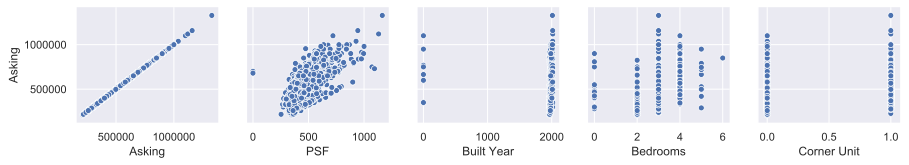

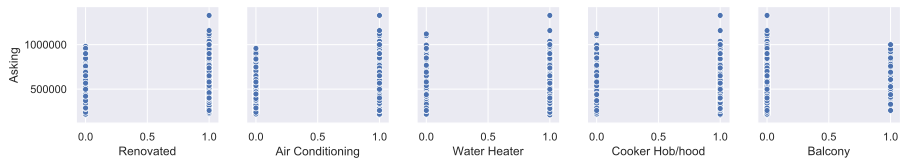

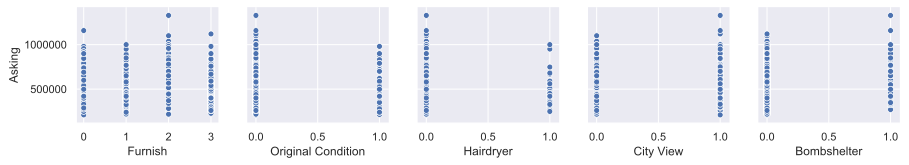

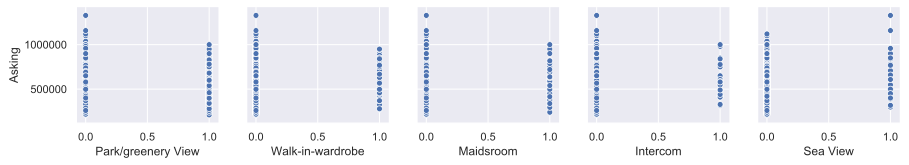

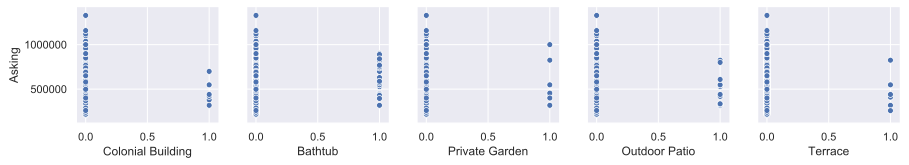

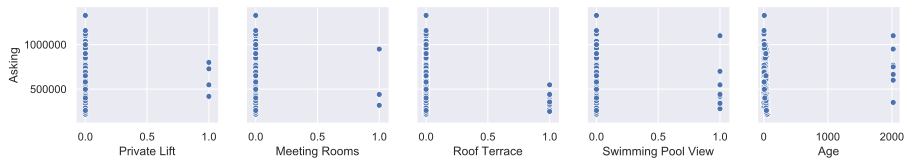

In [50]:
fig = plt.figure(figsize=(12,10))
sns.set()
for i in range(0, len(hdb_df5_num.columns), 5):
    ax = sns.pairplot(data=hdb_df5_num,
                x_vars=hdb_df5_num.columns[i:i+5],
                y_vars=['Asking'])
plt.tight_layout()  
plt.show() ;

In [51]:
# with open('../data/interim/selected_flats_modeling_df_6_feb.pkl', 'wb') as to_write:
#     pickle.dump(hdb_df5, to_write)

In [2]:
with open('../data/interim/selected_flats_modeling_df_6_feb.pkl', 'rb') as read_file:
    hdb_df5 = pickle.load(read_file)
    

In [3]:
hdb_df5.head(1)

Property Name  Property Type    Asking    PSF  Built Year  \
0  Bukit Batok Street 24  HDB Executive  560000.0  366.0  1997         

       Model                              Address     HDB Town  Bedrooms  \
0  Apartment  290B Bukit Batok Street 24 (653290)  Bukit Batok  4          

  Bathrooms         Land Tenure  Corner Unit  Renovated  Air Conditioning  \
0  2         LEASEHOLD/99 years  1.0          1.0        1.0                

   Water Heater  Cooker Hob/hood  Balcony  Furnish  Original Condition  \
0  1.0           1.0              1.0      0        0.0                  

   Hairdryer  City View  Bombshelter  Park/greenery View  Walk-in-wardrobe  \
0  0.0        0.0        0.0          0.0                 0.0                

   Maidsroom  Intercom  Sea View  Colonial Building  Bathtub  Private Garden  \
0  0.0        0.0       0.0       0.0                0.0      0.0              

   Outdoor Patio  Terrace  Private Lift  Meeting Rooms  Roof Terrace  \
0  0.0            0.0      0.0           0.0            0.0            

   Swimming Pool View  is_duplicated Model_edited  Age  \
0  0.0                 False          Apartment    23    

   Model_edited_label_encoded  HDB_Town_label_encoded  \
0  1                           3                        

   Land_Tenure_label_encoded  Property_Type_label_encoded HDB_Region  \
0  1                          6                            West        

   HDB_Region_label_encoded  
0  1

In [4]:
hdb_df5.pivot_table(index='HDB_Region', columns = 'Property Type', values = 'Asking',aggfunc=[np.mean, len]).round(2)

mean                                                   \
Property Type HDB 3 Rooms HDB 4 Rooms HDB 5 Rooms HDB Executive  HDB Jumbo   
HDB_Region                                                                   
Central        361961.60   575706.74   788780.27   897991.38     860000.00   
East           331470.59   492284.23   591108.00   715027.44     709333.33   
North          307429.87   378185.58   470942.86   590525.87     758777.60   
North_East     339547.64   469465.35   578843.78   688084.24     750000.00   
West           338176.89   460773.22   504888.38   625409.17    NaN          

                      len                                                  
Property Type HDB 3 Rooms HDB 4 Rooms HDB 5 Rooms HDB Executive HDB Jumbo  
HDB_Region                                                                 
Central        97.0        78.0        86.0        13.0          1.0       
East           34.0        103.0       72.0        36.0          3.0       
North          23.0        45.0        35.0        15.0          5.0       
North_East     42.0        122.0       108.0       29.0          1.0       
West           27.0        69.0        71.0        41.0         NaN

- Regardless of `Property Type`, HDBs in Central area are more expensive than other regions. 
- There are more 4- and 5- flats in North East region than other regions

In [50]:
len(hdb_df5.columns)
hdb_df5.columns

44

Index(['Property Name', 'Property Type', 'Asking', 'PSF', 'Model', 'Address',
       'HDB Town', 'Bedrooms', 'Bathrooms', 'Land Tenure', 'Corner Unit',
       'Renovated', 'Air Conditioning', 'Water Heater', 'Cooker Hob/hood',
       'Balcony', 'Furnish', 'Original Condition', 'Hairdryer', 'City View',
       'Bombshelter', 'Park/greenery View', 'Walk-in-wardrobe', 'Maidsroom',
       'Intercom', 'Sea View', 'Colonial Building', 'Bathtub',
       'Private Garden', 'Outdoor Patio', 'Terrace', 'Private Lift',
       'Meeting Rooms', 'Roof Terrace', 'Swimming Pool View', 'is_duplicated',
       'Age', 'Property_Type_label_encoded', 'Model_edited',
       'Model_edited_label_encoded', 'HDB_Town_label_encoded',
       'Land_Tenure_label_encoded', 'HDB_Region', 'HDB_Region_label_encoded'],
      dtype='object')

In [11]:
#drop `Area`, `private pool`, `garage`, `Property name`, `Address`, `Model`, 'Model_edited_label_encoded', 'HDB_Town_label_encoded',
       #'Land_Tenure_label_encoded'
modeling_variables = ['Asking', 'Property Type', 'PSF', 
       'HDB Town', 'Bedrooms', 'Bathrooms',
       'Land Tenure', 'Corner Unit', 'Renovated', 'Air Conditioning',
       'Water Heater', 'Cooker Hob/hood', 'Balcony', 'Furnish',
       'Original Condition', 'Hairdryer', 'City View', 'Bombshelter',
       'Park/greenery View', 'Walk-in-wardrobe', 'Maidsroom', 'Intercom',
       'Sea View', 'Colonial Building', 'Bathtub', 'Private Garden',
       'Outdoor Patio', 'Terrace', 'Private Lift', 'Meeting Rooms',
       'Roof Terrace', 'Swimming Pool View', 'Model_edited', 
       'Age', 'Property_Type_label_encoded', 'Model_edited', 'HDB_Region']
len(modeling_variables) 

37

In [12]:
modeling_df = hdb_df5[modeling_variables]
modeling_df.sample(1)

Asking Property Type    PSF    HDB Town  Bedrooms Bathrooms  \
1599  270000.0  HDB 3 Rooms   369.0  Ang Mo Kio  2         0          

             Land Tenure  Corner Unit  Renovated  Air Conditioning  \
1599  LEASEHOLD/99 years  0.0          1.0        1.0                

      Water Heater  Cooker Hob/hood  Balcony  Furnish  Original Condition  \
1599  1.0           1.0              0.0      0        0.0                  

      Hairdryer  City View  Bombshelter  Park/greenery View  Walk-in-wardrobe  \
1599  0.0        0.0        1.0          0.0                 0.0                

      Maidsroom  Intercom  Sea View  Colonial Building  Bathtub  \
1599  0.0        0.0       0.0       0.0                0.0       

      Private Garden  Outdoor Patio  Terrace  Private Lift  Meeting Rooms  \
1599  0.0             0.0            0.0      0.0           0.0             

      Roof Terrace  Swimming Pool View    Model_edited  Age  \
1599  0.0           0.0                 New Generation  40    

      Property_Type_label_encoded    Model_edited  HDB_Region  
1599  3                            New Generation  North_East

In [13]:
dummy_variable_list =  ['Property Type', 'Model_edited', 'Furnish','HDB Town', 'Land Tenure', 'HDB_Region']

In [14]:
#create dummy variables 
for variable in dummy_variable_list:
    dummied_variables = pd.get_dummies(modeling_df[variable], prefix = variable, drop_first = True)
    modeling_df1 = modeling_df.join(dummied_variables)
    modeling_df = modeling_df1
    
df_dum_variables = modeling_df1.columns.values.tolist()
to_keep = [i for i in df_dum_variables if i not in dummy_variable_list]

#final data col
model_df_final = modeling_df[to_keep]
model_df_final.columns.values
model_df_final.head(1)

array(['Asking', 'PSF', 'Bedrooms', 'Bathrooms', 'Corner Unit',
       'Renovated', 'Air Conditioning', 'Water Heater', 'Cooker Hob/hood',
       'Balcony', 'Original Condition', 'Hairdryer', 'City View',
       'Bombshelter', 'Park/greenery View', 'Walk-in-wardrobe',
       'Maidsroom', 'Intercom', 'Sea View', 'Colonial Building',
       'Bathtub', 'Private Garden', 'Outdoor Patio', 'Terrace',
       'Private Lift', 'Meeting Rooms', 'Roof Terrace',
       'Swimming Pool View', 'Age', 'Property_Type_label_encoded',
       'Property Type_HDB 4 Rooms', 'Property Type_HDB 5 Rooms',
       'Property Type_HDB Executive', 'Property Type_HDB Jumbo',
       'Model_edited_Apartment', 'Model_edited_Apartment',
       'Model_edited_Dbss', 'Model_edited_Dbss',
       'Model_edited_Design & Built', 'Model_edited_Design & Built',
       'Model_edited_Executive Apartment',
       'Model_edited_Executive Apartment', 'Model_edited_Improved',
       'Model_edited_Improved', 'Model_edited_Jumbo',
       

Asking    PSF  Bedrooms Bathrooms  Corner Unit  Renovated  \
0  560000.0  366.0  4         2         1.0          1.0         

   Air Conditioning  Water Heater  Cooker Hob/hood  Balcony  \
0  1.0               1.0           1.0              1.0       

   Original Condition  Hairdryer  City View  Bombshelter  Park/greenery View  \
0  0.0                 0.0        0.0        0.0          0.0                  

   Walk-in-wardrobe  Maidsroom  Intercom  Sea View  Colonial Building  \
0  0.0               0.0        0.0       0.0       0.0                 

   Bathtub  Private Garden  Outdoor Patio  Terrace  Private Lift  \
0  0.0      0.0             0.0            0.0      0.0            

   Meeting Rooms  Roof Terrace  Swimming Pool View  Age  \
0  0.0            0.0           0.0                 23    

   Property_Type_label_encoded  Property Type_HDB 4 Rooms  \
0  6                            0                           

   Property Type_HDB 5 Rooms  Property Type_HDB Executive  \
0  0                          1                             

   Property Type_HDB Jumbo  Model_edited_Apartment  Model_edited_Apartment  \
0  0                        1                       1                        

   Model_edited_Dbss  Model_edited_Dbss  Model_edited_Design & Built  \
0  0                  0                  0                             

   Model_edited_Design & Built  Model_edited_Executive Apartment  \
0  0                            0                                  

   Model_edited_Executive Apartment  Model_edited_Improved  \
0  0                                 0                       

   Model_edited_Improved  Model_edited_Jumbo  Model_edited_Jumbo  \
0  0                      0                   0                    

   Model_edited_Maisonette  Model_edited_Maisonette  Model_edited_Model A  \
0  0                        0                        0                      

   Model_edited_Model A  Model_edited_Multi Generation  \
0  0                     0                               

   Model_edited_Multi Generation  Model_edited_New Generation  \
0  0                              0                             

   Model_edited_New Generation  Model_edited_Others  Model_edited_Others  \
0  0                            0                    0                     

   Model_edited_Premium Apartment  Model_edited_Premium Apartment  \
0  0                               0                                

   Model_edited_Simplified  Model_edited_Simplified  Model_edited_Standard  \
0  0                        0                        0                       

   Model_edited_Standard  Model_edited_Terrace  Model_edited_Terrace  \
0  0                      0                     0                      

   Model_edited_Apartment  Model_edited_Apartment  Model_edited_Dbss  \
0  1                       1                       0                   

   Model_edited_Dbss  Model_edited_Design & Built  \
0  0                  0                             

   Model_edited_Design & Built  Model_edited_Executive Apartment  \
0  0                            0                                  

   Model_edited_Executive Apartment  Model_edited_Improved  \
0  0                                 0                       

   Model_edited_Improved  Model_edited_Jumbo  Model_edited_Jumbo  \
0  0                      0                   0                    

   Model_edited_Maisonette  Model_edited_Maisonette  Model_edited_Model A  \
0  0                        0                        0                      

   Model_edited_Model A  Model_edited_Multi Generation  \
0  0                     0                               

   Model_edited_Multi Generation  Model_edited_New Generation  \
0  0                              0                             

   Model_edited_New Generation  Model_edited_Others  Model_edited_Others  \
0  0                            0                    0                     

   Model_edited_Premium Apartm

In [15]:
model_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1156 entries, 0 to 1979
Columns: 127 entries, Asking to HDB_Region_West
dtypes: float64(26), int64(3), object(1), uint8(97)
memory usage: 429.5+ KB


In [17]:
with open('../data/processed/selected_flats_modeling_df.pkl', 'wb') as to_write:
    pickle.dump(model_df_final, to_write)
with open('../data/processed/selected_flats_model_df_pre_dummy.pkl', 'wb') as to_write:
    pickle.dump(modeling_df, to_write)